In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pickle
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

TypeError: only integer scalar arrays can be converted to a scalar index

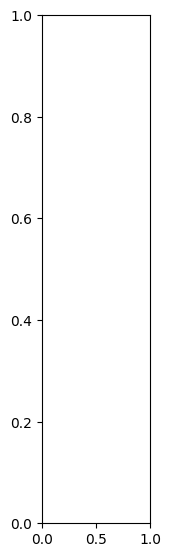

In [13]:
# Load your data (assuming output.csv is your dataset)
data = pd.read_csv("output.csv")
data = data.drop_duplicates()

# Prepare your features and target (adjust columns as needed)
X = data.drop(columns=['gravity', 'AccID', 'vehicleID', 'num_veh'], errors='ignore')
y = data['gravity']

# Adjust target labels to start from 0 instead of 1
y = y - y.min()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Optionally, save your test data for later use
X_test.to_csv("X_test.csv", index=False)

# Load the trained model and test data for interpretability
if os.path.exists("model.pkl") and os.path.exists("X_test.csv"):
    with open("model.pkl", "rb") as f:
        model = pickle.load(f)

    X_test = pd.read_csv("X_test.csv")
    X_sample = X_test.sample(n=50, random_state=42)
    X_sample_array = X_sample.to_numpy()
    
    # SHAP Explanation
    explainer = shap.Explainer(model, X_sample_array)
    shap_values = explainer(X_sample_array)

    # SHAP Summary Plot
    shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns.tolist(), show=False)
    fig_summary = plt.gcf()

    
   # SHAP Dependence Plot for the first feature
   # feature_name = X_sample.columns[0]
   # shap.dependence_plot(feature_name, shap_values, X_sample_array, show=False)
   # fig_dependence = plt.gcf()

    # LIME Explanation
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_test.values,
        feature_names=X_test.columns.tolist(),
        class_names=['Uninjured', 'Minor Injury', 'Hospitalized Injury', 'Fatal'],
        mode='classification'
    )
    exp = explainer_lime.explain_instance(X_test.iloc[0], model.predict_proba)
    fig_lime = exp.as_pyplot_figure()

    # Display results
    plt.show(fig_summary)
   # plt.show(fig_dependence)
    plt.show(fig_lime)
else:
    print("Model or test dataset not found.")
